# Compare methods notebook

In [8]:
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modelproblem import ModelProblem
from result_classes import Result,MethodResults

In [9]:
prob_name = "mRNA_self_reg"
methods = ["smc", "pmc"]#, "ptmcmc"]

mod_prob = ModelProblem(prob_name)
mod_prob.initialize()

grouped_results = [MethodResults(x) for x in methods]

for method, group_obj in zip(methods, grouped_results):
	result_dir = f"results/{prob_name}/{method}/"
	fnames = glob.glob(result_dir + "*.pkl")
	for fname in fnames:
		#print(fname)
		with open(fname, "rb") as f:
			results = pickle.load(f)
		result_obj = Result(results)
		group_obj.add_result(result_obj)
print(type(mod_prob.problem))		

<class 'pypesto.problem.base.Problem'>


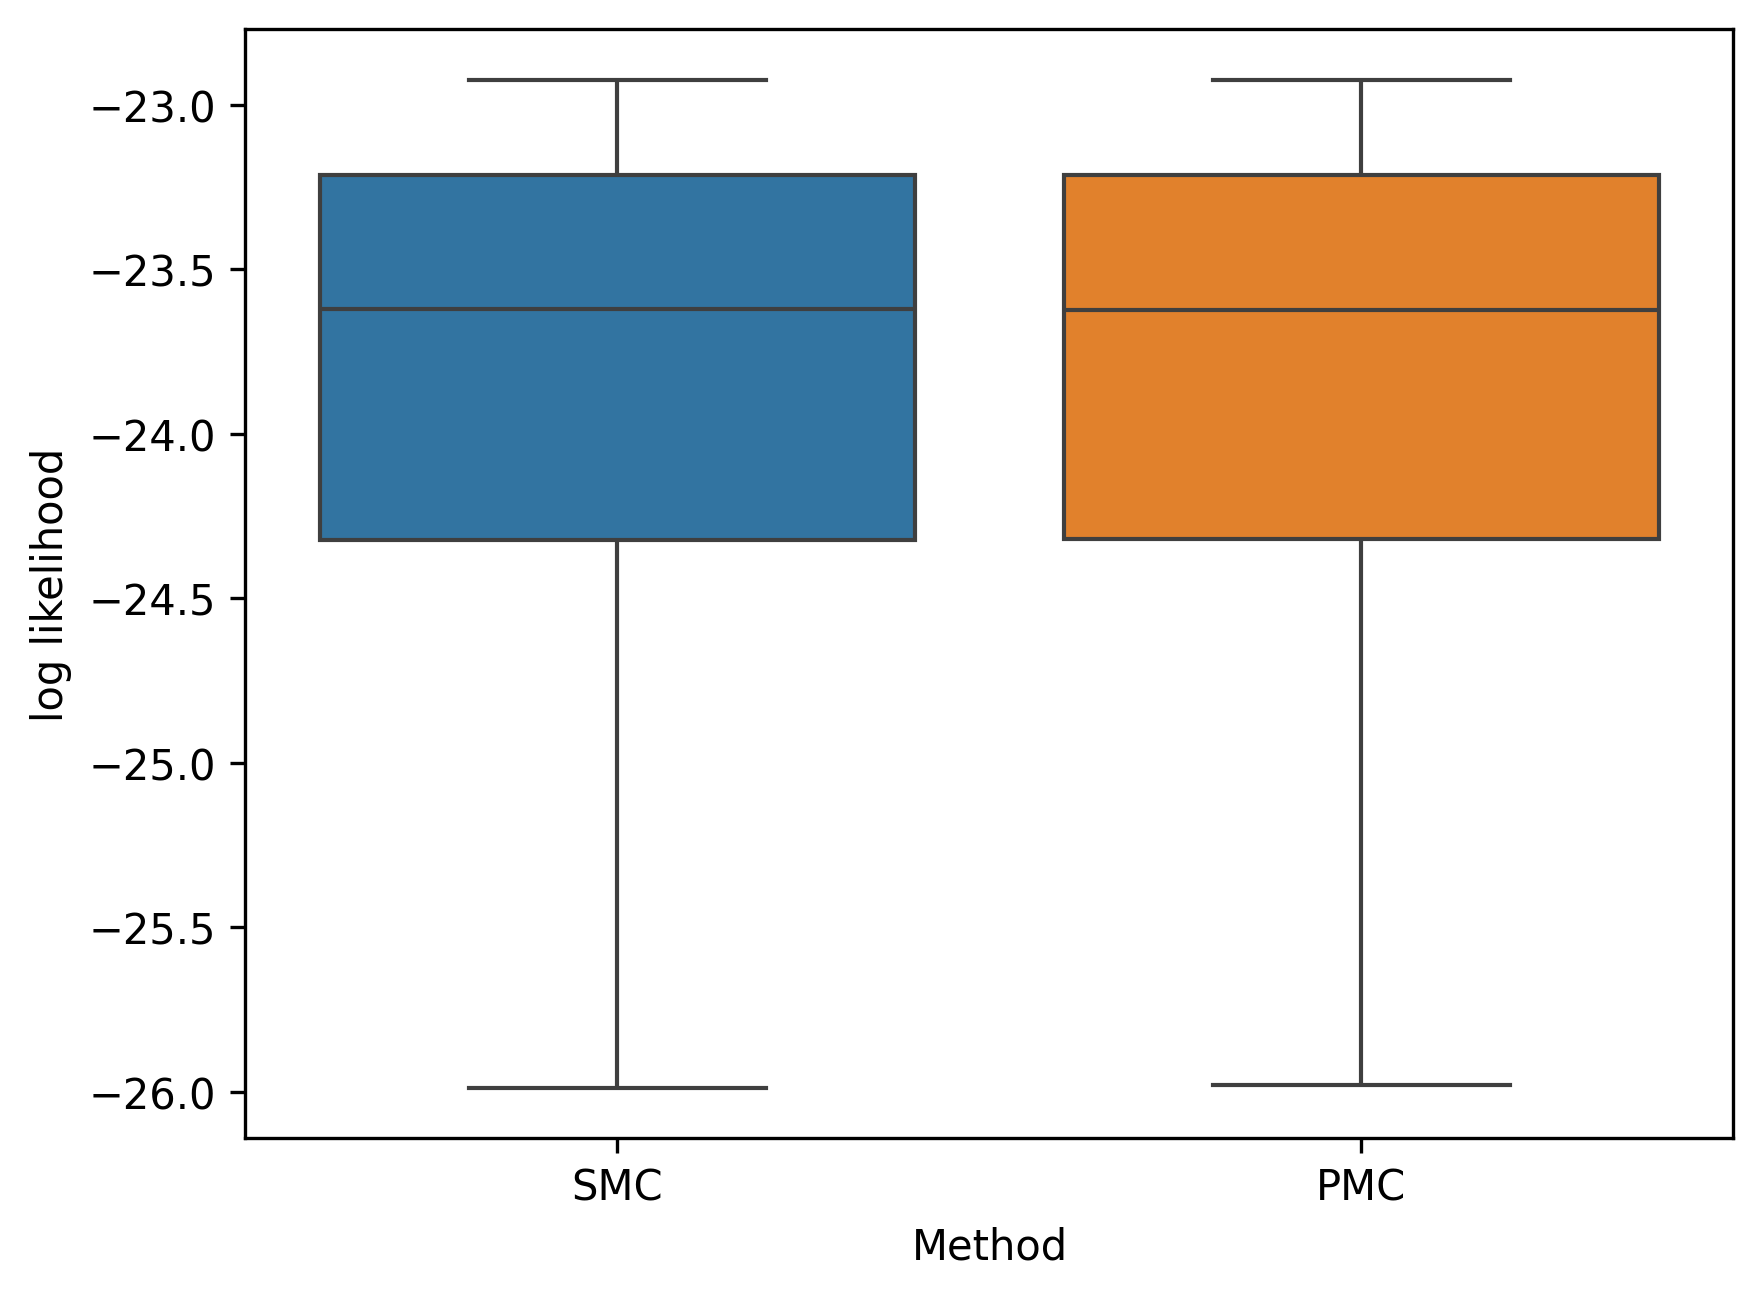

In [10]:
plt.figure(dpi=300)
llhs = np.array([x.get_llhs().flatten() for x in grouped_results])
#llhs[llhs<-20000] = -7500
llh_df = pd.DataFrame(columns=methods, data=llhs.T)
sns.boxplot(llh_df, showfliers=False)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel("log likelihood");

In [11]:
if not True:
	fixed_idxs = mod_prob.problem.x_fixed_indices
	par_names = mod_prob.problem.x_names
	x=np.array(par_names)
	mask=np.full(len(par_names),True,dtype=bool)
	mask[fixed_idxs]=False
	fit_par_names=x[mask]

	all_ks_stats=[]

	ks_df = pd.DataFrame(columns=["Param", "Method", "KS"])
	for i, name in enumerate(fit_par_names):
		# assumes all runs have the same model parameters
		for runs in grouped_results:
			ks_stats , pvals = runs.calc_pairwise_matrix(par_index=i)
			all_ks_stats.append(ks_stats[np.triu_indices(ks_stats.shape[0], k = 1)])
			for run_ks in ks_stats:
				for ks_stat in run_ks:
					new_row = {"Param":name, "Method":runs.abbr, "KS":ks_stat}
					ks_df.loc[len(ks_df)] = new_row

	ks_df = ks_df.drop(ks_df[ks_df["KS"] == 0].index)

	sns.violinplot(data=ks_df, x="Param", y="KS", hue="Method")

MAX NUM FUNC CALLS: 359000


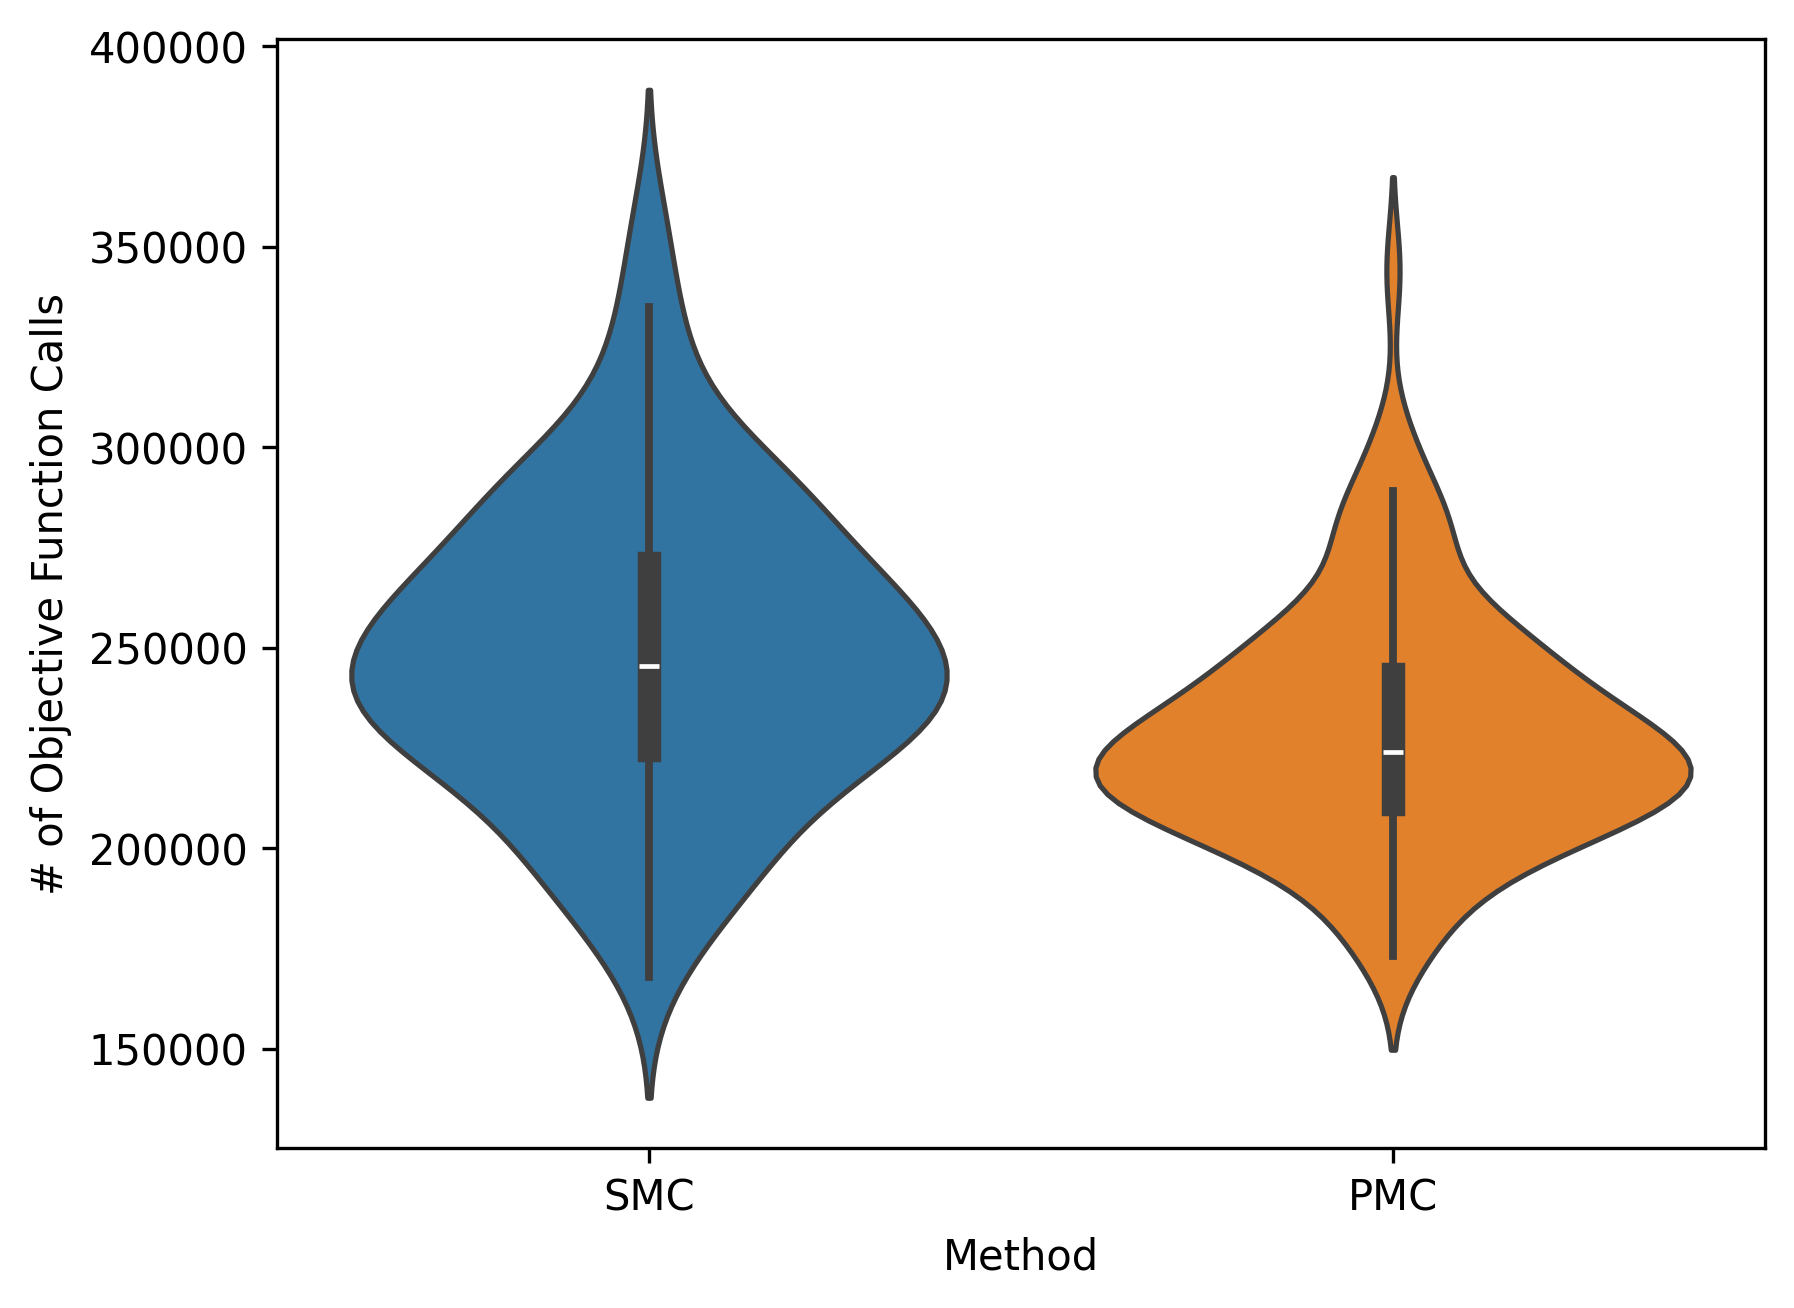

In [12]:
plt.figure(dpi=300)
calls = np.array([x.get_fun_calls() for x in grouped_results])
call_df = pd.DataFrame(columns=methods, data=calls.T)
sns.violinplot(call_df)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel("# of Objective Function Calls");
print(f"MAX NUM FUNC CALLS: {np.max(calls)}")

/home/larkinit/anaconda3/envs/test1/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 51.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/larkinit/anaconda3/envs/test1/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 73.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


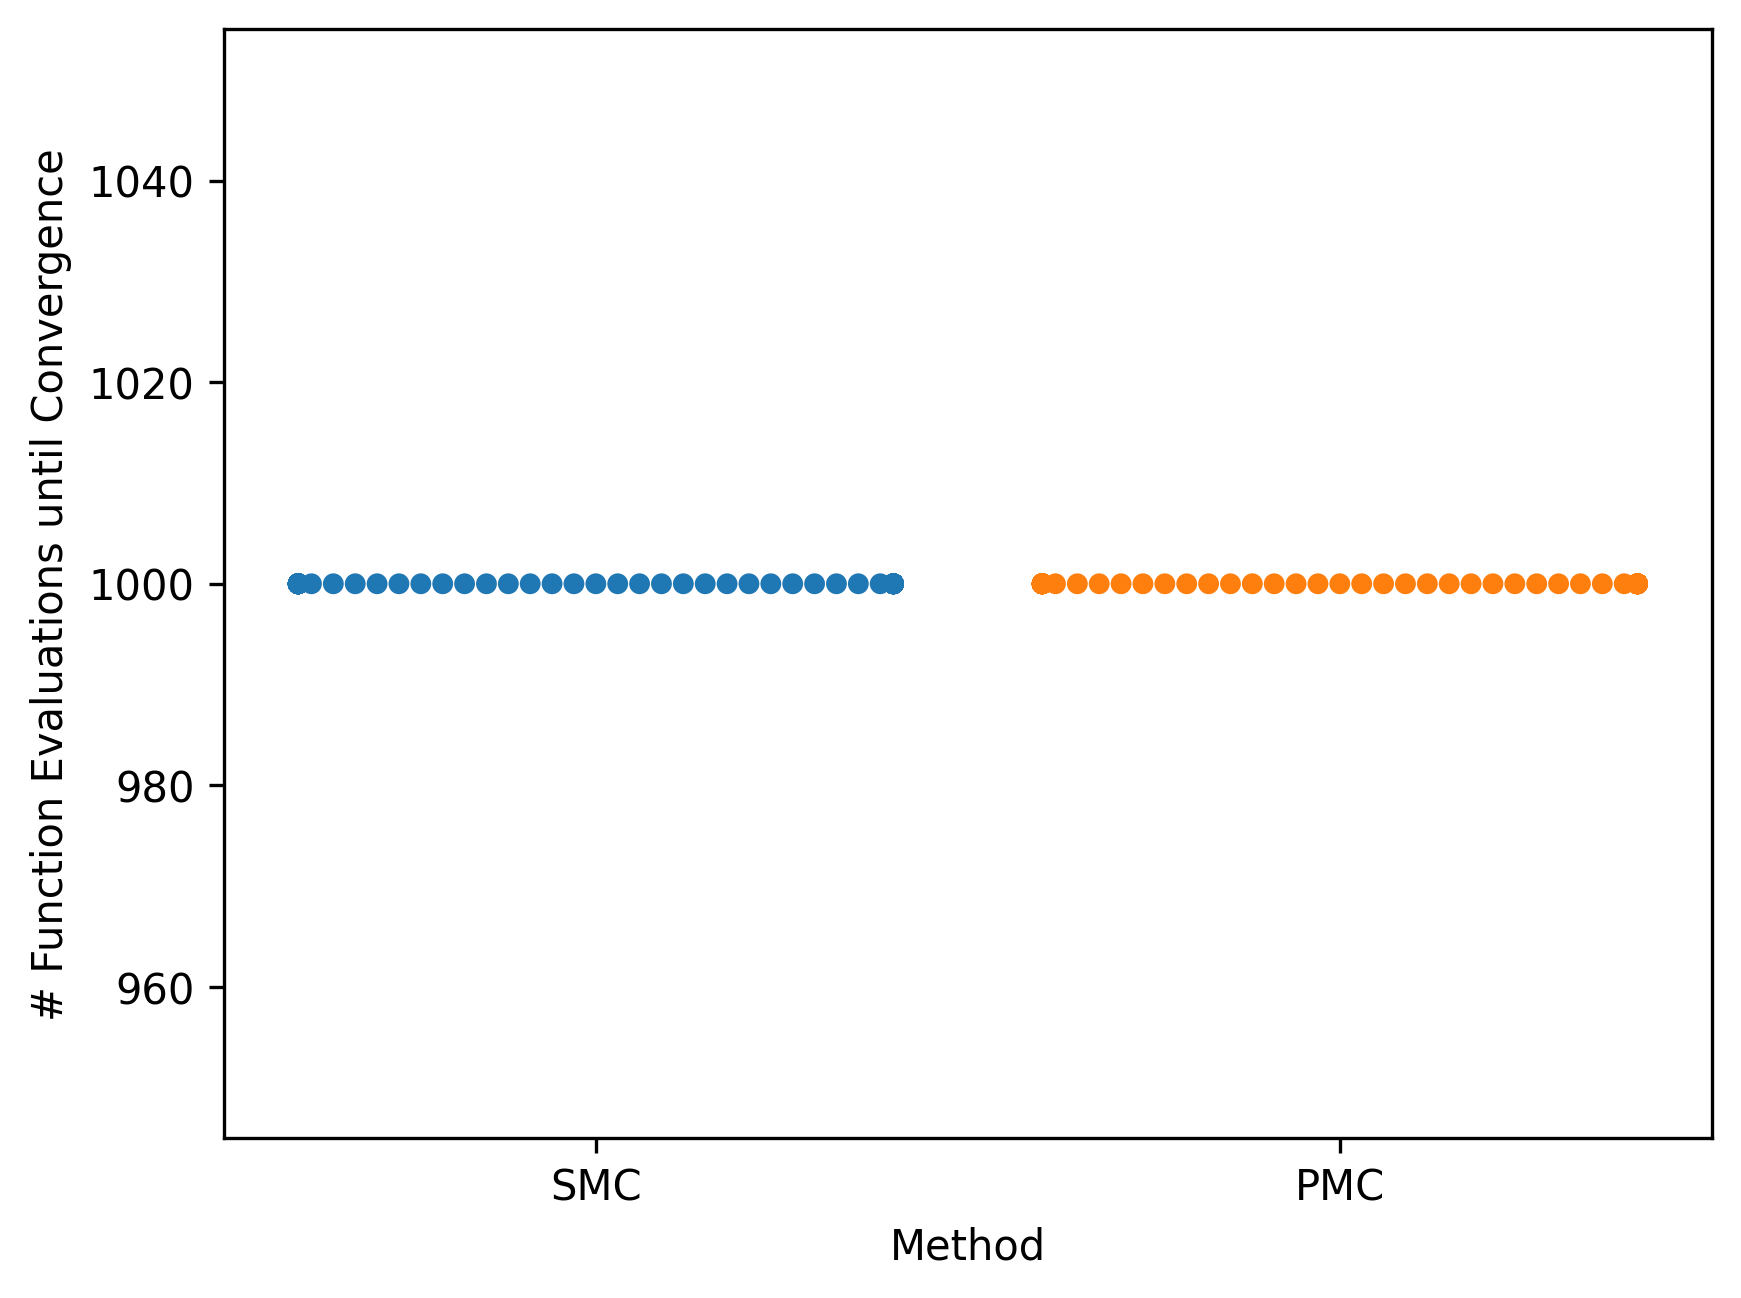

In [13]:
llh_threshold = -1000000
plt.figure(dpi=300)
#grouped_results[0].get_convergence_times(llh_threshold)
conv = np.array([x.get_convergence_times(llh_threshold) for x in grouped_results])
conv_df = pd.DataFrame(columns=methods, data=conv.T)

sns.swarmplot(conv_df)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); 
plt.ylabel(f"# Function Evaluations until Convergence");